In [3]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from igraph import *
import networkx as nx
from collections import Counter
import importlib
from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re
import visualize_util
from visualize_util import *




In [4]:
p = os.path.join("sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256","final_structures6_1")

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
file_dict = {int(re.findall(r'\d+', Path(file).name)[0]):file for file in files}
f_l = [int(re.findall(r'\d+', Path(file).name)[0]) for file in files]
max_epoch = max(file_dict.keys())

last_epoch = file_dict[max_epoch]

# max_epoch = 203
# last_epoch = os.path.join(model_dir,"model_checkpoint"+str(max_epoch)+".pth")
print(last_epoch)

vis_path = os.path.join(p, "evaluation", str(max_epoch))
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)


sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1/model
sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1/model/model_checkpoint346.pth


In [5]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
print(ix)
# print(df5.iloc[[300]])


344


<Figure size 640x480 with 0 Axes>

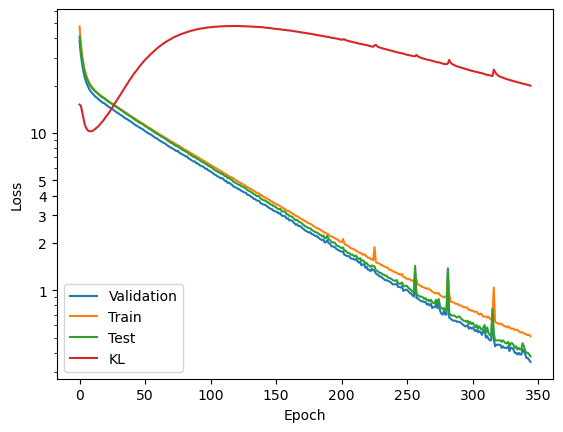

In [ ]:
plt.figure(dpi = 100)
fig1, ax1 = plt.subplots()
ax1.plot(df5.iloc[:,3], label='Validation')
ax1.plot(df5.iloc[:,0], label='Train')
ax1.plot(df5.iloc[:,4], label='Test')
ax1.plot(df5.iloc[:,2], label='KL')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


ax1.legend()
ax1.set_yticks([10,5,4,3,2,1])
ax1.set_yticklabels([10,5,4,3,2,1])
ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
# plt.plot(df3.iloc[:2949,4], label='Total')

In [7]:

print(args.seed)
print(args)
print(type(args.seed))
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)
print(sys.version)


1
DotMap(data_type='BN', data_set='sachs', data_name='final_structures6', nvt=13, max_n=13, save_appendix='', save_interval=1, sample_number=20, no_test=False, reprocess=False, keep_old=False, only_test=False, small_train=False, model='DVAE_NOBATCHNORM', hs=512, nz=13, beta=0.1, save_start=0, early_stop_patience=50, early_stop_delta=0.01, lr=0.0001, epochs=3000, batch_size=256, load_latest_model=False, continue_from=None, bidirectional=False, infer_batch_size=32, no_cuda=False, all_gpus=False, seed=1, cuda=True, file_dir='/home/banfizsombor/D-VAE', res_dir='/home/banfizsombor/D-VAE/sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1', scheduler_dir='/home/banfizsombor/D-VAE/sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1/scheduler', optimizer_dir='/home/banfizsombor/D-VAE/sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1/optimizer', model_dir='/home/banfizsom

In [8]:
graph_args = DotMap()
graph_args.max_n = args.nvt
graph_args.num_vertex_type = args.max_n
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
print(graph_args)
print(last_epoch)
load_module_state(model,last_epoch)

cuda:0
DotMap(max_n=13, num_vertex_type=13, START_TYPE=0, END_TYPE=1)
sachs_graphsize11_13dim_latent_KL0.1_DVAE_NOBATCHNORM_hs512_batchsize256/final_structures6_1/model/model_checkpoint346.pth


In [9]:
all_data = []
all_data_cleaned = []
train_data = []
test_data = []
graph_path = "/home/banfizsombor/processed_mcmc/processed_mcmc_sachs_1/save_all"
for ix,filename in enumerate(tqdm(os.listdir(graph_path))):
    path = os.path.join(graph_path, filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        graph2 = graph
        all_data.append(graph2)
        all_data_cleaned.append(graph2)
    

train_data = all_data[:30000]
test_data = all_data[30000:]
train_data_cleaned = all_data_cleaned[:30000]
test_data_cleaned = all_data_cleaned[30000:]

number_of_graphs = len(train_data)

print(len(all_data))
print(len(train_data))



100%|██████████| 155491/155491 [20:51<00:00, 124.21it/s]

155491
30000


In [10]:
def DAG_hash2(graph):
        g = graph
        nodeTypes = sorted(g.vs["type"])
        n2 =  "".join([str(nodeType) for nodeType in nodeTypes + [0]] + [str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
        return int(n2)
DAG_hash2(all_data_cleaned[0])

1234567891011120050134581001580135810000123581003456810015013456810013580123458907110

In [11]:
print("Memory used before empty cache:" + str(torch.cuda.memory_allocated()))
torch.cuda.empty_cache()
mu = None
print("Memory used after empty cache:" + str(torch.cuda.memory_allocated()))

Memory used before empty cache:15212544
Memory used after empty cache:15212544


In [12]:
# ENCODE ALL DATA
import gc
latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
percect_recon = 0
i = 0
data_batch = []
for ix,data in enumerate(tqdm(train_data)):
    data_copy = data.copy()
    data_batch.append(data_copy)
    
    if len(data_batch) == args.batch_size or ix == len(train_data) - 1:
        cnt = 0
        mu, logvar = model.encode(data_batch)
        mu_cpu = mu.cpu().detach().numpy()
        latents.extend(mu_cpu)
        data_batch = []
        torch.cuda.empty_cache()
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(args.max_n-1, 'in')
    minus_edges = len(null_edges) + len(end_edges)
    # mu  = np.append(mu, data.ecount()- minus_edges)

    






    
    extended.append(data.ecount()- minus_edges)
        
        # print("Memory used before empty cache:" + str(torch.cuda.memory_allocated()))
        
        # print("Memory used after empty cache:" + str(torch.cuda.memory_allocated()))
        # input()

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

100%|██████████| 30000/30000 [02:12<00:00, 227.06it/s]

(30000, 13)


In [13]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [ 0.3799739   0.14203301 -0.38798165 -0.10695138 -0.1434018  -1.0212262
  0.58804864  0.16508469 -0.04993094 -0.7674603  -0.81881505 -0.4100531
  1.0914441 ]
Z_std: [1.8048846 1.6054448 1.7720605 1.7635965 1.6581581 1.505956  1.6324855
 1.7076441 1.6374497 1.507415  1.613405  1.7560687 1.4747082]
Z norm: 1093.8508


<class 'numpy.ndarray'>


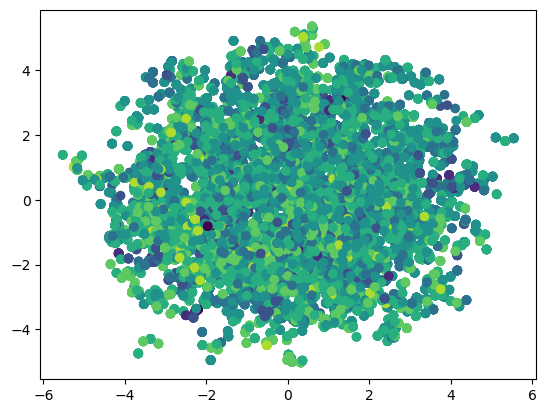

In [14]:
a = latents.reshape((number_of_graphs,args.nz))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))

fig, ax = plt.subplots(facecolor=(1, 1, 1))
scatter = ax.scatter(components[:,0], components[:,1], c=extended)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
fig_name = os.path.join(vis_path, "train_data_encoded")
fig.savefig(fig_name,bbox_inches='tight')
plt.show()



In [15]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    Wrapped_G = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 100
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Wrapped_G.append(GraphWrapper(g))
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid, Wrapped_G


valid, invalid, Zs_valid, Zs_invalid, Wrapped_G = prior_validity()
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 100/100 [00:12<00:00,  7.93it/s]

0
1000


In [16]:
print(invalid[0])
print(invalid[0].vs["type"])

IGRAPH D--T 6 6 --
+ attr: type (v)
+ edges:
0->1 1->2 2->3 1->3 3->4 4->5
[0, 4, 9, 5, 7, 1]


In [17]:
print(number_of_graphs)
print(len(valid))
valid_cleaned = valid.copy()


for g in valid_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

30000
0


In [18]:
# print(test_data[0])
iv_cnt =0
for iv in invalid:
    if len(set(iv.vs["type"])) != args.max_n:
        iv_cnt += 1
    else:
        print(iv)
        input()

In [19]:
for g in train_data_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

In [20]:
# TODO
# Hash all_data, create {hash, index} map, map hashes, create array from indexes, np hist
import importlib
import sys
importlib.reload(visualize_util)
train_data_hashes  = {}

for ix,a_d in enumerate(train_data_cleaned):
    h = DAG_hash2(a_d)
    train_data_hashes[h] = ix
    # print(h)
# print(all_data_hashes)


In [21]:
hash_indexes =[]
hashes = []
# hashes = [ visualize_util.DAG_hash(w_g) for w_g in valid]
# print(all_data_hashes)
for w_g in valid_cleaned:
    h = DAG_hash2(w_g)
    if h in train_data_hashes:
        ix = train_data_hashes[h]
    else:
        print("meh")
    # print(h)
    hash_indexes.append(ix)
    hashes.append(h)

# print(len(hashes))
# counter = collections.Counter(hashes)
# c_values = list(counter.values())
# print(c_values)
# hashes.append(visualize_util.DAG_hash(valid[0]))

In [22]:
counter = collections.Counter(hashes)
c_values = list(counter.values())

# print(c_values)

In [23]:
print(np.max(c_values))
print(hashes[0])

ValueError: zero-size array to reduction operation maximum which has no identity

48138


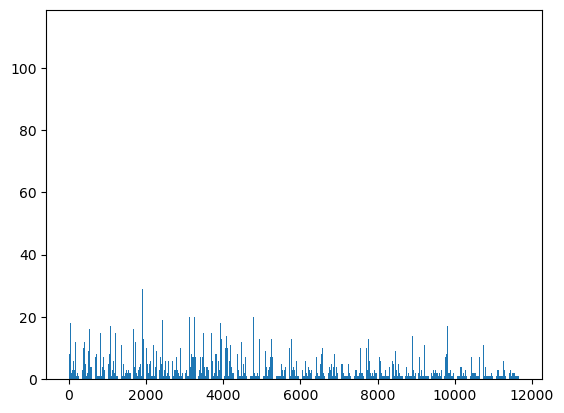

[13, 9, 4, 8, 18, 1, 12, 7, 2, 13, 15, 2, 1, 2, 4, 8, 10, 7, 10, 3, 1, 7, 5, 2, 29, 8, 5, 13, 15, 7, 9, 2, 17, 10, 6, 3, 11, 7, 3, 3, 2, 18, 3, 4, 12, 2, 9, 9, 15, 8, 2, 7, 1, 2, 6, 6, 8, 1, 3, 1, 5, 2, 6, 3, 14, 1, 5, 2, 12, 5, 16, 1, 32, 4, 8, 10, 2, 10, 14, 5, 5, 1, 13, 1, 2, 9, 1, 3, 7, 16, 1, 2, 1, 3, 6, 43, 1, 1, 3, 2, 4, 6, 4, 6, 1, 1, 1, 2, 1, 17, 14, 1, 12, 6, 8, 1, 1, 1, 5, 6, 10, 2, 4, 1, 21, 1, 2, 18, 1, 3, 2, 2, 1, 2, 1, 2, 1, 2, 17, 3, 5, 5, 23, 2, 7, 3, 3, 4, 3, 26, 16, 5, 10, 1, 11, 11, 11, 1, 7, 19, 11, 4, 3, 13, 4, 15, 2, 14, 4, 12, 12, 12, 14, 16, 8, 8, 1, 3, 5, 4, 9, 3, 6, 4, 1, 16, 3, 3, 3, 8, 2, 7, 13, 1, 5, 20, 1, 1, 4, 1, 12, 2, 15, 6, 4, 3, 4, 4, 5, 8, 3, 1, 3, 1, 4, 6, 6, 2, 6, 8, 3, 2, 12, 2, 1, 1, 3, 1, 7, 6, 1, 2, 1, 1, 3, 5, 1, 1, 13, 3, 4, 10, 22, 2, 1, 1, 1, 1, 1, 1, 10, 12, 2, 1, 4, 1, 1, 1, 4, 11, 9, 4, 30, 4, 2, 5, 21, 8, 11, 7, 10, 5, 1, 28, 11, 1, 5, 9, 3, 3, 6, 16, 10, 2, 3, 8, 2, 9, 10, 9, 1, 3, 2, 6, 2, 5, 3, 11, 8, 4, 13, 7, 12, 7, 3, 6, 1, 9, 1

In [ ]:
mapped_hashes = [ train_data_hashes[h] if h in train_data_hashes else number_of_graphs for h in hashes]
print(len(mapped_hashes))

counter = collections.Counter(mapped_hashes)
c_values = list(counter.values())
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()
print(c_values)
print(len(c_values))

In [ ]:
print(mapped_hashes[:10])
print(np.max(mapped_hashes))
print(number_of_graphs)
print(list(train_data_hashes.values())[-1])

[226, 15837, 16132, 9245, 2744, 17038, 25101, 23851, 24040, 14614]
29278
29281
29280


In [ ]:
# print(all_data_hashes)

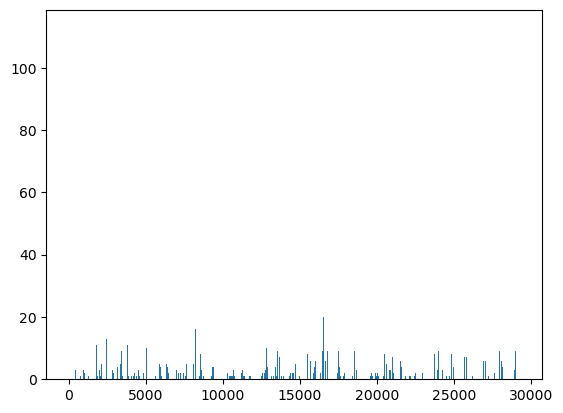

In [ ]:
hist1 = np.histogram(mapped_hashes,bins = number_of_graphs)
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [ ]:
print(hist1[0])
print(len(hist1[0]))
print(np.argmax(hist1[0]))
all_set = set(all_data_hashes.keys())
valid_set = set(hashes)

missing = all_set - valid_set
print(len(valid_set))
print(missing)
print(len(missing))

[1 0 0 ... 0 0 5]
29281
21113
11689
{234560045056000, 23456030560256000, 2345603456045056000, 23456046040023040, 234560350560256000, 23456045026050050, 234560450560000, 2345603400040450, 2345600023560200, 2345605602050050, 2345603400302600, 2345600256023560200, 2345600450560020, 2345605050040340, 234560402560024600, 234560346050560030, 2345604602460602400, 234560025002020, 23456004600234020, 23456004506026020, 234560402002346020, 234560026050600, 2345603460036034600, 23456046020034600, 2345604505600040, 234560300260360230, 2345603003023400, 2345603002360234030, 2345605604606000, 2345600450560050, 234560346050560050, 23456002450260020, 2345604505600050, 234560025002040, 23456004600234040, 234560350060600, 2345603460600234040, 234560402002346040, 23456050250236002350, 234560024500240450, 23456004020240450, 234560045602046020, 234560450003020, 234560460030030, 2345603060203600, 2345600602603600, 234560450003030, 234560045602046040, 234560460030040, 23456002450202460240, 23456045050560600,

In [ ]:
print(hist1)


(array([1, 0, 0, ..., 0, 0, 5]), array([2.00000000e+00, 2.99982924e+00, 3.99965848e+00, ...,
       2.92760003e+04, 2.92770002e+04, 2.92780000e+04]))


In [ ]:
uni = np.random.randint(0,542,number_of_graphs)
uni2 = np.random.randint(0,542,number_of_graphs)
m_mean =np.mean(hist1[0][:-2])
m_median =np.median(hist1[0][:-2])
m_std = np.std(hist1[0][:-2])
m_max = np.max(hist1[0][:-2])
m_max_ix = np.argmax(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0][:-2])
non_zeros = np.count_nonzero(hist1[0][:-2])
versatility = non_zeros/number_of_graphs
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Max index: " + str(m_max_ix))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
print("Versatility:" + str(versatility))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, max_epoch, args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid),versatility])



Mean: 1.6439427576078418
Median: 0.0
Std: 3.498942784554467
Max: 113
Max index: 21113
Distance from uniform distribution: 268.9235583523269
Uni to Uni: 1.5785663057955674
Versatility:0.3991666951265326


In [ ]:
print(hist1[0][:-2])

print(non_zeros)

[1 0 0 ... 3 0 0]
11688


29281


<BarContainer object of 543 artists>

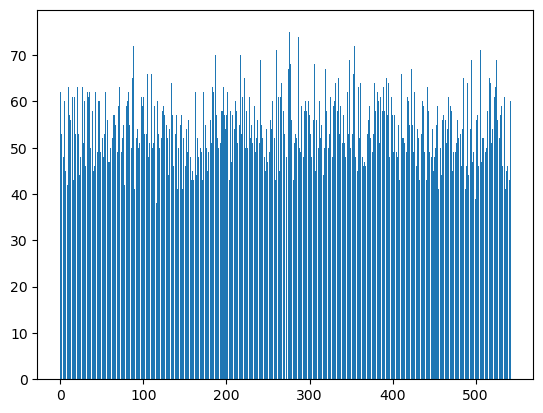

In [ ]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

(48138, 14)


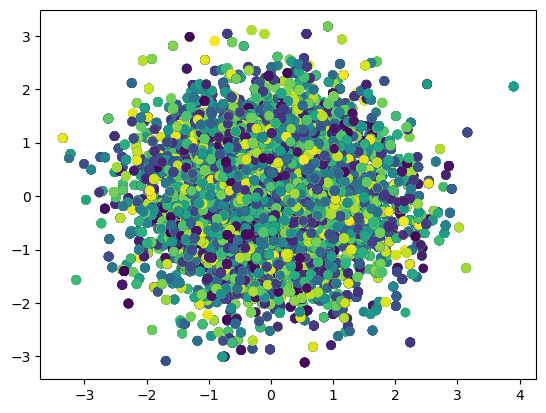

In [ ]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=mapped_hashes)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

21112
113
113


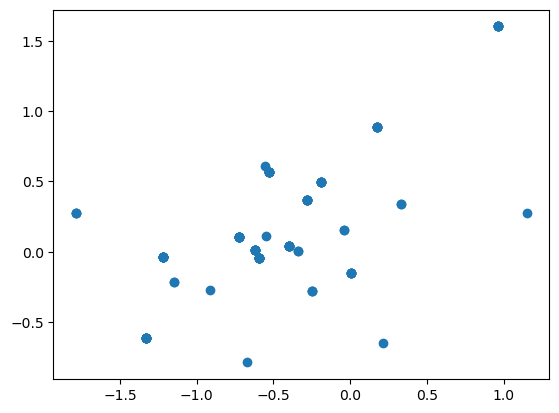

In [ ]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(mapped_hashes)) if mapped_hashes[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])
fig_name = os.path.join(vis_path, "most_common")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

(1862, 14)


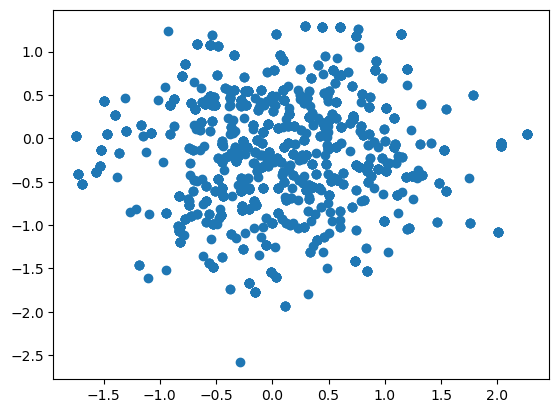

: 

In [ ]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])